In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
from file_cache import *


from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,
    CenterCrop,
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,
    RandomGamma,
    Resize,
    Rotate,
    Normalize,
)



2020-06-14 22:53:39,623 util_log.py[153] INFO Start the program at:amax7, 127.0.1.1, with:Load module


File_cache: Adjust notebook work fold to:/share/felix/pj/dynamic_unet/


In [2]:

img_size = height, width = 360*2, 480*2
class CamvidDS(Dataset):
    def __init__(self, ds_type='train'):
        train_file_list = glob('./input/camvid/images/*.png')
        df = pd.DataFrame({'img_file':train_file_list})
        df['img_name'] = df.img_file.apply(lambda val: os.path.basename(val))
        df['label_path'] = df.img_file.apply(lambda val: val.replace('.png', '_P.png').replace('images', 'labels'))
        valid_list = pd.read_csv('./input/camvid/valid.txt', header=None).iloc[:,0]        
        df['valid'] = df.img_name.isin(valid_list)
        
        
        self.ds_type = ds_type
        
        if ds_type=='train':
            print(df.valid.value_counts())
            self.df = df.loc[df.valid==False]
        else:
            self.df = df.loc[df.valid==True]

        original_height, original_width = height, width
        size = 224
        crop_size = np.random.uniform(0.9, 1)
        self.aug_train = Compose([
#             OneOf([RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
#                    PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)], p=1),
            #CenterCrop(int(size*crop_size), int(size*crop_size)),
            #VerticalFlip(p=0.5),
            #Rotate(limit=(-50, 50)),
            Resize(height=height, width=width),
            Normalize()
        ])

        self.aug_val = Compose([
            Resize(height=height, width=width),
            Normalize()
        ])
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, index):
        from PIL import Image
        image = self.df.img_file.iloc[index]
        #print(image)
        image = np.array(Image.open(image).convert('RGB'))

        mask = self.df.label_path.iloc[index]
        #print(mask)
        mask = np.array(Image.open(mask))
        
        

        if self.ds_type=='train':
            augmented = self.aug_train(image=image, mask=mask)
        else:
            augmented = self.aug_val(image=image, mask=mask)

        image, mask = augmented['image'], augmented['mask']

        return torch.FloatTensor(image).permute([2, 0, 1]), torch.LongTensor(mask)#.cuda()

print('====='*10)
print('img size', CamvidDS()[0][0].shape)
print('====='*10)
len(CamvidDS()[0] )

False    600
True     101
Name: valid, dtype: int64
img size torch.Size([3, 720, 960])
False    600
True     101
Name: valid, dtype: int64


2

In [3]:


#Image.open('./input/camvid/images/0016E5_07979.png')

In [4]:
from efficientnet_pytorch import EfficientNet
from dynamic_unet.base import *

# import ipdb
# ipdb.set_trace()
# def efficient_unet(name='5', in_channels=3):
#     from efficientnet_pytorch import EfficientNet
#     class EfficientNet_(EfficientNet):
#         def __init__(self, *args, **kwargs):
#             super().__init__(*args, **kwargs)

#         def forward(self, inputs):
#             x = self.extract_features(inputs)
#             return x
#     return EfficientNet_.from_pretrained(f'efficientnet-b{name}', in_channels=in_channels)

def unet_resnet34( pretrained: bool = True, blur_final: bool = True,
                 norm_type: Optional[NormType] = NormType, split_on: Optional[SplitFuncOrIdxList] = None,
                 blur: bool = False,
                 self_attention: bool = False, y_range: Optional[Tuple[float, float]] = None, last_cross: bool = True,
                 bottle: bool = False, cut: Union[int, Callable] = None,
                 n_classes=32, img_size=img_size, in_channels=1,
                 **learn_kwargs: Any) -> Learner:
    "Build Unet learner from `data` and `arch`."
    "blur: do maxpolling or not"
    from fastai.vision import models
    arch: Callable = models.resnet34
    body = create_body(arch, pretrained, cut)
    from fastai.vision import models
    from dynamic_unet.base import DynamicUnet
    
#     moduleList = flatten_moduleList(body)
#     print(len(moduleList))
#     for child in moduleList[:-2]:
#         for param in child.parameters():
#             param.requires_grad = False
    print('img_size', img_size)
    model = to_device(
        DynamicUnet(body, n_classes=n_classes, img_size=img_size, blur=blur, blur_final=blur_final,
                                self_attention=self_attention, y_range=y_range, norm_type=norm_type,
                                last_cross=last_cross,
                                bottle=bottle), 'cuda')
    return model

class Dynamic_Model(pl.LightningModule):

    def __init__(self,  n_classes=32, in_channels=3):
        super(Dynamic_Model, self).__init__()
        #encoder = efficient_unet(7, in_channels)
         
        self.unet =  unet_resnet34()


    def forward(self, x):
        # called with self(x)
        return self.unet(x)

    def training_step(self, batch, batch_nb):
        # REQUIRED
        x, y = batch
        #print(x.shape, y.shape)
        y_hat = self(x)
        #print(y_hat.shape, y.shape, y.max())
        loss = F.cross_entropy(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        return {'val_loss': F.cross_entropy(y_hat, y)}

    def validation_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        print(self.current_epoch, tensorboard_logs)
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

   
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=3e-4, betas=(0.9, 0.99))
        # scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=self.hparams.lr,
        #                                           steps_per_epoch=len(self.train_dataloader()),
        #                                           epochs=self.hparams.epochs)

        scheduler = optim.lr_scheduler.StepLR(opt, gamma=0.8, step_size=10)

        print('schedule', scheduler)
        return [opt], [scheduler]

    def train_dataloader(self):
        # REQUIRED
        return DataLoader(CamvidDS('train'), batch_size=2)

    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(CamvidDS('valid'), batch_size=2)

    


img_size (720, 960)
   sn       layer    c    w    h               size
2   2        ReLU   64  360  480  (1, 64, 360, 480)
4   4  Sequential   64  180  240  (1, 64, 180, 240)
5   5  Sequential  128   90  120  (1, 128, 90, 120)
6   6  Sequential  256   45   60   (1, 256, 45, 60)
7   7  Sequential  512   23   30   (1, 512, 23, 30)


GPU available: True, used: True
2020-06-14 22:53:53,874 distrib_data_parallel.py[251] INFO GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
2020-06-14 22:53:53,879 distrib_data_parallel.py[297] WARNING No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
2020-06-14 22:53:53,881 distrib_data_parallel.py[323] INFO CUDA_VISIBLE_DEVICES: [0]


schedule <torch.optim.lr_scheduler.StepLR object at 0x7faa4213f810>
0 {'val_loss': tensor(4.7905, device='cuda:0')}
False    600
True     101
Name: valid, dtype: int64


LR finder stopped early due to diverging loss.
2020-06-14 22:54:37,452 lr_finder.py[174] INFO LR finder stopped early due to diverging loss.


0.0002089296130854041

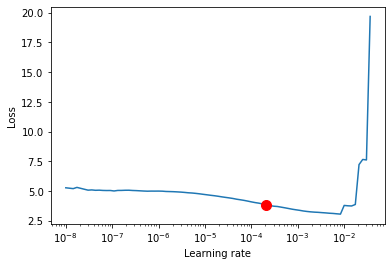

In [5]:
dynamic_model = Dynamic_Model()
trainer = pl.Trainer(gpus=1, weights_summary=None, ) 
lr_finder = trainer.lr_find(dynamic_model)


fig = lr_finder.plot(suggest=True); 

fig.show()
lr_finder.suggestion()

In [6]:

dynamic_model = Dynamic_Model()

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(   gpus=1,
                         max_epochs=20,
                         num_sanity_val_steps=0,
                         #show_progress_bar=False,
                         #progress_bar_refresh_rate=0,
                         weights_summary=None, 
                    )    

trainer.fit(dynamic_model)  


img_size (720, 960)
   sn       layer    c    w    h               size
2   2        ReLU   64  360  480  (1, 64, 360, 480)
4   4  Sequential   64  180  240  (1, 64, 180, 240)
5   5  Sequential  128   90  120  (1, 128, 90, 120)
6   6  Sequential  256   45   60   (1, 256, 45, 60)
7   7  Sequential  512   23   30   (1, 512, 23, 30)


GPU available: True, used: True
2020-06-14 22:54:43,058 distrib_data_parallel.py[251] INFO GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
2020-06-14 22:54:43,060 distrib_data_parallel.py[297] WARNING No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
2020-06-14 22:54:43,060 distrib_data_parallel.py[323] INFO CUDA_VISIBLE_DEVICES: [0]


schedule <torch.optim.lr_scheduler.StepLR object at 0x7faa53ef6b90>
False    600
True     101
Name: valid, dtype: int64


0 {'val_loss': tensor(0.8661, device='cuda:0')}


1 {'val_loss': tensor(0.5682, device='cuda:0')}


2 {'val_loss': tensor(0.5035, device='cuda:0')}


3 {'val_loss': tensor(0.4900, device='cuda:0')}


4 {'val_loss': tensor(0.3823, device='cuda:0')}


5 {'val_loss': tensor(0.3732, device='cuda:0')}


6 {'val_loss': tensor(0.3496, device='cuda:0')}


7 {'val_loss': tensor(0.2884, device='cuda:0')}


8 {'val_loss': tensor(0.3093, device='cuda:0')}


9 {'val_loss': tensor(0.2922, device='cuda:0')}


10 {'val_loss': tensor(0.2817, device='cuda:0')}


11 {'val_loss': tensor(0.2926, device='cuda:0')}


12 {'val_loss': tensor(0.3395, device='cuda:0')}


13 {'val_loss': tensor(0.3500, device='cuda:0')}


14 {'val_loss': tensor(0.3520, device='cuda:0')}


15 {'val_loss': tensor(0.3131, device='cuda:0')}


16 {'val_loss': tensor(0.3478, device='cuda:0')}


17 {'val_loss': tensor(0.3302, device='cuda:0')}


18 {'val_loss': tensor(0.3950, device='cuda:0')}


19 {'val_loss': tensor(0.3765, device='cuda:0')}



1